In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl

# 数据预处理

将match_id重新搞成易读取的形式

将时间戳化为秒

网球比赛给分不均衡，可能会影响我们的计算，故将其均衡化，即0,1,2,3,4对应0,15,30,40,ad

In [2]:
data = pd.read_csv('Wimbledon_featured_matches.csv')

# 修改时间戳
def time_trans(time):
    hours, minutes, seconds = map(int, time.split(':'))
    return hours*3600+minutes*60+seconds

data['elapsed_time'] = data['elapsed_time'].apply(time_trans)

# 修改id
idDict = {}
for id in data['match_id'].unique():
    if id not in idDict:
        idDict[id] = len(idDict)
data['match_id'] = data['match_id'].map(idDict)

# 修改得分
scoreDict = {'0': 0, '15': 1, '30': 2, '40': 3, 'AD': 4, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10}
data['p1_score'] = data['p1_score'].map(scoreDict)
data['p2_score'] = data['p2_score'].map(scoreDict)

# 网球比赛的比分

## 一局

（1）每胜1球得1分，先胜4分者胜1局。
（2）双方各得3分时为“平分”，平分后，净胜两分为胜1局。国际网球赛都是用英语单词Love，以及数字15、30、40分别表示0、1、3、4。

## 一盘

（1）一方先胜6局为胜1盘。
（2）双方各胜5局时，一方净胜两局为胜1盘

### 决胜局计分制

在每盘的局数为6平时，有以下两种计分制。
（1）长盘制：一方净胜两局为胜1盘。
（2）短盘制（抢七）：决胜盘除外，除非赛前另有规定，一般应按以下办法执行。

A.先得7分者为胜该局及该盘（若分数为6平时，一方须净两分）。
B.首先发球员发第1分球，对方发第2、3分球，然后轮流发两分球，直到比赛 结束。
C.第1分球在右区发，第2分球在左区发，第3分球在右区发。
D.每6分球和决胜局结束都要交换场地。

短盘制的计分
（1）第1个球（0：0），发球员A发1分球，1分球之后换发球。
（2）第2、3个球（报1：0或0：1，不报15：0或0：15），由B发球，B连发两分球后换发球，先从左区发球。
（3）第4、5个球（报3：0或1：2，2：1，不报40：0或15：30， 30：15），由A发球，A连发两球后换发球后换发球，先从左区发球。
（4）第6、7个球（报3：3或2：4，4：2或1：5，5：1或6：0，0： 6） ，由B发1分球之后交换场地，若比赛未结束，B继续发第7个球。
（5）比分打到5：5，6：6，7：7，8：8……时，需连胜两分才能决定谁为胜方。但在记分表上则统一写为7：6。
（6）决胜局打完之后，双方队员交换场地。

五盘三胜制度

# 题目1

1. 给出整个比赛流程中哪一个更好的模型（以及好了多少），并对比赛流程进行可视化。

# 思路

我们使用得分概率来给出表现的预期，表现越好，则得到下一分的概率就会更高。

先基于分差给出一个表现上的结果。

（根据tandf_cjas2048_2982中论文内容）momentum：两次击球后分差（短期表现）。使用全局量。下面给出player1的（player2为相反数）

若分差呈上升趋势，则player1表现好，若下降趋势，则player2表现好

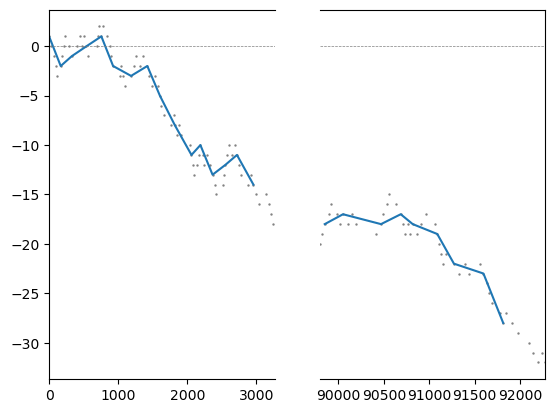

In [3]:
def xyCal(gameData, interval):
    pointErr = np.zeros(gameData.shape[0])
    sumOfPoint1 = 0
    sumOfPoint2 = 0
    j = 0
    for j in range(0,gameData.shape[0]):
        if gameData['point_victor'].iloc[j] == 1:
            sumOfPoint1 += 1
        if gameData['point_victor'].iloc[j] == 2:
            sumOfPoint2 += 1
        pointErr[j] = sumOfPoint1 - sumOfPoint2
    examplingPointErr = np.zeros((int)(np.floor(gameData.shape[0]/interval)))
    examplingTime = np.zeros((int)(np.floor(gameData.shape[0]/interval)))
    for counter in range(0,(int)(np.floor(gameData.shape[0]/interval))):
        examplingPointErr[counter] = pointErr[counter*interval]
        examplingTime[counter] = gameData['elapsed_time'].iloc[counter*interval]
    xyData = pd.DataFrame()
    exyData = pd.DataFrame()
    xyData['time'] = gameData['elapsed_time']
    xyData['pointErr'] = pointErr
    exyData['pointErr'] = examplingPointErr
    exyData['time'] = examplingTime
    return xyData, exyData
def drawFig(gameData, interval):
    xyData, exyData = xyCal(gameData, interval)
    diff = np.diff(xyData['time'])
    breakPoints = [0]
    if np.max(diff) > 3600:
        breakPoints = np.where(diff > 3600)[0]
    if breakPoints[0] != 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.set_xlim(xyData['time'].min(), xyData['time'].iloc[breakPoints[0]])
        ax2.set_xlim(xyData['time'].iloc[breakPoints[0]+1],xyData['time'].max())
        ax1.spines.right.set_visible(False)
        ax2.spines.left.set_visible(False)
        ax2.tick_params(left=False)
        ax1x, ax2x = xyData['time'].iloc[0:breakPoints[0]], xyData['time'].iloc[breakPoints[0]+1:]
        ax1y, ax2y = xyData['pointErr'].iloc[0:breakPoints[0]], xyData['pointErr'].iloc[breakPoints[0]+1:]
        diff = np.diff(exyData['time'])
        breakPoints = np.where(diff > 3600)[0]
        ax1ex, ax2ex = exyData['time'].iloc[0:breakPoints[0]], exyData['time'].iloc[breakPoints[0]+1:]
        ax1ey, ax2ey = exyData['pointErr'].iloc[0:breakPoints[0]], exyData['pointErr'].iloc[breakPoints[0]+1:]
        ax1.plot(ax1ex, ax1ey)
        ax2.plot(ax2ex, ax2ey)
        ax1.scatter(ax1x, ax1y, s=2,marker='.',c='grey')
        ax2.scatter(ax2x, ax2y, s=2,marker='.',c='grey')
        ax1.axhline(0,color='grey',linestyle='--',linewidth=0.5)
        ax2.axhline(0,color='grey',linestyle='--',linewidth=0.5)
    else:
        fig0, ax = plt.subplots()
        ax.scatter(xyData['time'],xyData['pointErr'],s=2,marker='.',c='grey')
        ax.plot(exyData['time'],exyData['pointErr'])
        ax.axhline(0,color='grey',linestyle='--',linewidth=0.5)
gameData = data[data['match_id'] == 2]
drawFig(gameData,5)

为计算概率，需要一些特征。
上几次击球的得分结果：(长期表现)或许总进球概率是一个可行的值，不过为了让其更可靠，固定选择发球（或不发球）是的概率

In [4]:
# 特征工程